In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **SUL DATASET**

Il dataset è una versione pre-processata del dataset **OASIS Alzheimer's Detection** (un dataset di immagini MRI del cervello di 461 pazienti) utilizzato per rilevare i segni precoci dell’Alzheimer.

Poiché le immagini MRI sono 3D, sono state divise lungo l'asse z (l'asse della profondità del cervello) in 175 fette e sono state selezionate le fette che vanno dalla 55 esima alla 124 esima al fine di ridurre il numero di immagini e concentrarsi sulle sezioni cerebrali rilevanti per l'analisi della demenza; Questo approccio ha generato immagini 2D per ogni paziente.

Lo stesso approccio è stato utilizzato per le versioni delle MRI con segmentazione delle aree cerebrali offerte da OASIS effettuate tramite FSL FAST.

****
****

Le immagini sono classificate in **quattro sottoclassi**, in base alla progressione della malattia:

*   Moderate dementia (affetto da demenza)

*   Very mild dementia (affetto da demenza molto lieve)
* Mild dementia (affetto da demenza lieve)
* Non-demented (non affetto da demenza)


*La classificazione dei pazienti è stata effettuata sulla base delle valutazioni CDR (Clinical Dementia Rating), un punteggio che valuta la severità della demenza.*



In [4]:
# Import

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import zipfile
import os
import matplotlib.patches as mpatches
import numpy as np
from PIL import Image
import math
import shutil
import pandas as pd

# **OPERAZIONI SUL DATASET**

### Operazioni preliminari

In [5]:
# Estrazione dataset

zip_path = "/content/drive/My Drive/Alzheimer-detection-project/oasis 1.zip"
extract_folder = "/content/Alzheimer-detection-project"

os.makedirs(extract_folder, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print("File estratti:", os.listdir(extract_folder))


File estratti: ['__MACOSX', 'oasis 1']


In [6]:
oasis1_path = os.path.join(extract_folder, "oasis 1")
categories = ['Moderate Dementia', 'Mild Dementia', 'Very Mild Dementia', 'Non Demented']
for category in categories:
    category_path = os.path.join(oasis1_path, category)
    mri_segmented_path=os.path.join(category_path, 'mri segmented')
    mri_path= os.path.join(category_path, 'mri scan')

In [7]:
# Rimozione files inutili
for dirpath, dirnames, filenames in os.walk(oasis1_path):
    for filename in filenames:
        if filename == ".DS_Store":
            file_path = os.path.join(dirpath, filename)
            os.remove(file_path)
            print(f"Rimosso: {file_path}")


Rimosso: /content/Alzheimer-detection-project/oasis 1/.DS_Store
Rimosso: /content/Alzheimer-detection-project/oasis 1/Mild Dementia/.DS_Store
Rimosso: /content/Alzheimer-detection-project/oasis 1/Mild Dementia/mri scan/.DS_Store
Rimosso: /content/Alzheimer-detection-project/oasis 1/Mild Dementia/mri segmented/.DS_Store
Rimosso: /content/Alzheimer-detection-project/oasis 1/Very Mild Dementia/.DS_Store
Rimosso: /content/Alzheimer-detection-project/oasis 1/Very Mild Dementia/mri scan/.DS_Store
Rimosso: /content/Alzheimer-detection-project/oasis 1/Very Mild Dementia/mri segmented/.DS_Store
Rimosso: /content/Alzheimer-detection-project/oasis 1/Moderate Dementia/.DS_Store
Rimosso: /content/Alzheimer-detection-project/oasis 1/Moderate Dementia/mri scan/.DS_Store
Rimosso: /content/Alzheimer-detection-project/oasis 1/Moderate Dementia/mri segmented/.DS_Store
Rimosso: /content/Alzheimer-detection-project/oasis 1/Non Demented/.DS_Store
Rimosso: /content/Alzheimer-detection-project/oasis 1/Non Dem

### **VISUALIZZAZIONE GRAFICI** di distribuzione delle classi

numero foto Moderate Dementia: 140
numero foto Mild Dementia: 1960
numero foto Very Mild Dementia: 5006
numero foto Non Demented: 23520


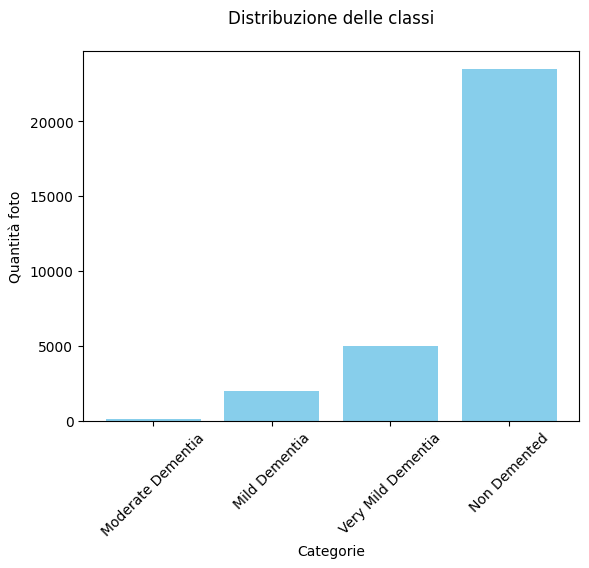

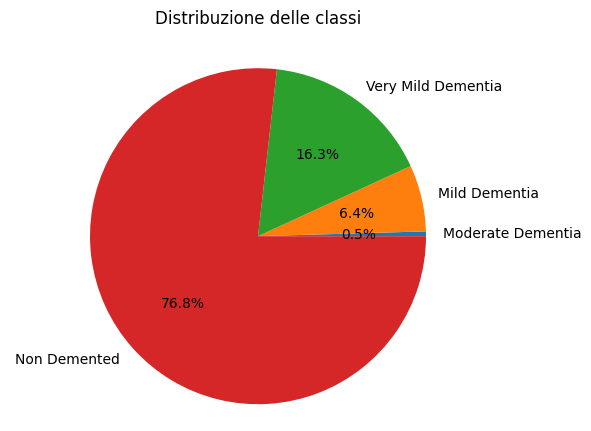

In [8]:
# Numero di immagini per categoria - grafico di distribuzione delle classi

somma=0
valori=[]

for category in categories:
    category_path = os.path.join(oasis1_path, category)
    mri_path= os.path.join(category_path, 'mri scan')
    for patient in os.listdir(mri_path):
      images= os.listdir(os.path.join(mri_path, patient))
      somma=somma+len(images)
    print(f'numero foto {category}: {somma}')
    valori.append(somma)
    somma=0

# Visualizzazione tramite istogramma
plt.bar(categories, valori, color='skyblue')
plt.title('Distribuzione delle classi', pad=20)
plt.xlabel('Categorie')
plt.xticks(rotation=45)
plt.ylabel('Quantità foto')
plt.show()
print(f" ")

# Visualizzazione tramite grafico a torta
plt.pie(valori, labels=categories, autopct='%1.1f%%', startangle=0)
plt.title('Distribuzione delle classi',pad=20)
plt.axis('equal')
plt.show()




### **APPROCCI ALLO SBILANCIAMENTO DEL DATASET**

Il dataset è estremamente sbilanciato.

 **APPROCCI ADOTTATI PER AFFRONTARE IL PROBLEMA DELLO SBILANCIAMENTO**:

- **Unione delle due classi minoritarie** (Mild Dementia e Moderate Demenntia) dato che il focus del progetto è una early detection dell'alzheimer.
- **Downsampling parziale della classe maggioritaria** (Non Demented) per limitare il rischio di bias.
- **Bilanciamento delle classi tramiti pesi** (class weights) durante la fase di addestramento per compensare le differenze residue.

In [9]:
# Sposto i files da Moderate dementia in Mild Dementia
mod_d_path=os.path.join(oasis1_path, "Moderate Dementia")
mild_d_path=os.path.join(oasis1_path, "Mild Dementia")
source_path=os.path.join(mod_d_path, "mri scan")
dest_path=os.path.join(mild_d_path, "mri scan")

for folder in os.listdir(source_path):
  source_file=os.path.join(source_path, folder)
  shutil.move(source_file, dest_path)

source_path=os.path.join(mod_d_path, "mri segmented")
dest_path=os.path.join(mild_d_path, "mri segmented")
for folder in os.listdir(source_path):
  source_file=os.path.join(source_path, folder)
  shutil.move(source_file, dest_path)

In [10]:
# Rinomino la cartella
mild_to_mod_path= os.path.join(oasis1_path, "Mild to Moderate Dementia")
if os.path.exists(mild_d_path):
    os.rename(mild_d_path, mild_to_mod_path)
    print("Cartella rinominata con successo.")
else:
    print("La cartella di origine non esiste.")

categories = ['Mild to Moderate Dementia', 'Very Mild Dementia', 'Non Demented']

# Elimino la cartella vuota
cartella_da_eliminare = os.path.join(oasis1_path, "Moderate Dementia")
shutil.rmtree(cartella_da_eliminare)

Cartella rinominata con successo.


In [11]:
# Downsampling della classe maggioritaria
nd_path=os.path.join(oasis1_path, "Non Demented")
mri_path=os.path.join(nd_path, "mri scan")
mri_seg_path=os.path.join(nd_path, "mri segmented")

n=180
folders=os.listdir(mri_path)
to_delete=random.sample(folders, n)

for folder in to_delete:
  folder_seg= f"{folder.strip()} seg"
  path=os.path.join(mri_path, folder)
  path_seg=os.path.join(mri_seg_path, folder_seg)
  shutil.rmtree(path)
  shutil.rmtree(path_seg)

### **VISUALIZZAZIONE GRAFICI** di distribuzione delle classi in seguito a approcci per il bilanciamento

numero foto Mild to Moderate Dementia: 2100
numero foto Very Mild Dementia: 5006
numero foto Non Demented: 10920


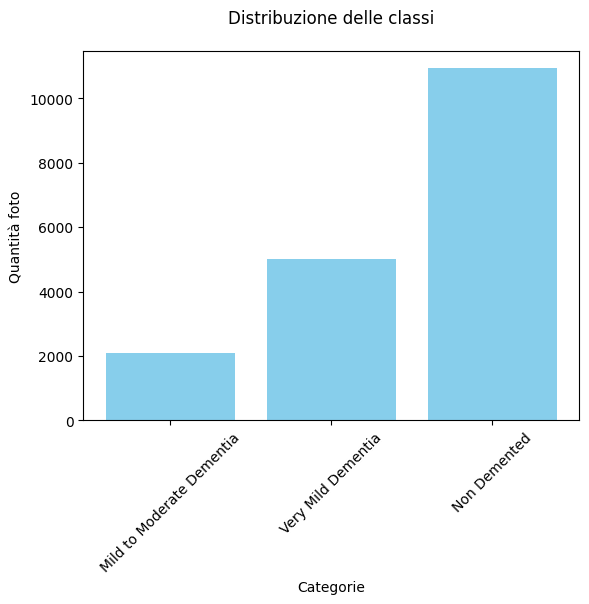

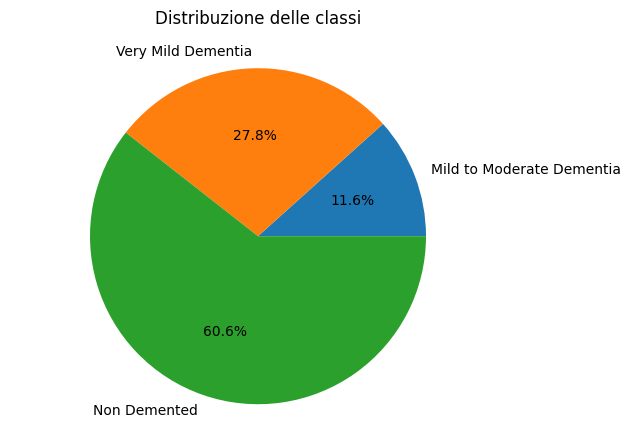

In [12]:
# Numero di immagini per categoria - grafico di distribuzione delle classi
#dopo unione delle cartelle e downsampling

somma=0

valori=[]

for category in categories:
    category_path = os.path.join(oasis1_path, category)
    mri_path= os.path.join(category_path, 'mri scan')
    for patient in os.listdir(mri_path):
      images= os.listdir(os.path.join(mri_path, patient))
      somma=somma+len(images)
    print(f'numero foto {category}: {somma}')
    valori.append(somma)
    somma=0

# Visualizzazione tramite istogramma
plt.bar(categories, valori, color='skyblue')
plt.title('Distribuzione delle classi', pad=20)
plt.xlabel('Categorie')
plt.xticks(rotation=45)
plt.ylabel('Quantità foto')
plt.show()
print(f" ")

# Visualizzazione tramite grafico a torta
plt.pie(valori, labels=categories, autopct='%1.1f%%', startangle=0)
plt.title('Distribuzione delle classi',pad=20)
plt.axis('equal')
plt.show()

### **VISUALIZZAZIONE DI IMMAGINI A CAMPIONE** dal dataset

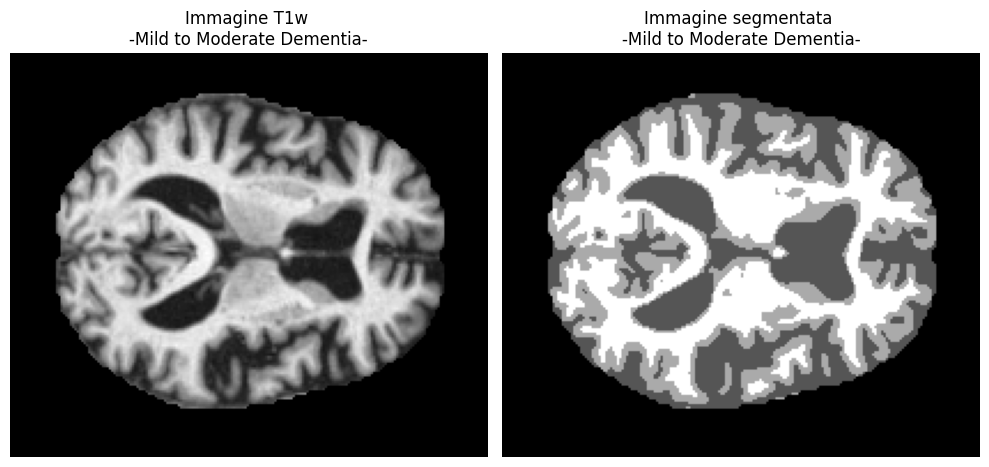

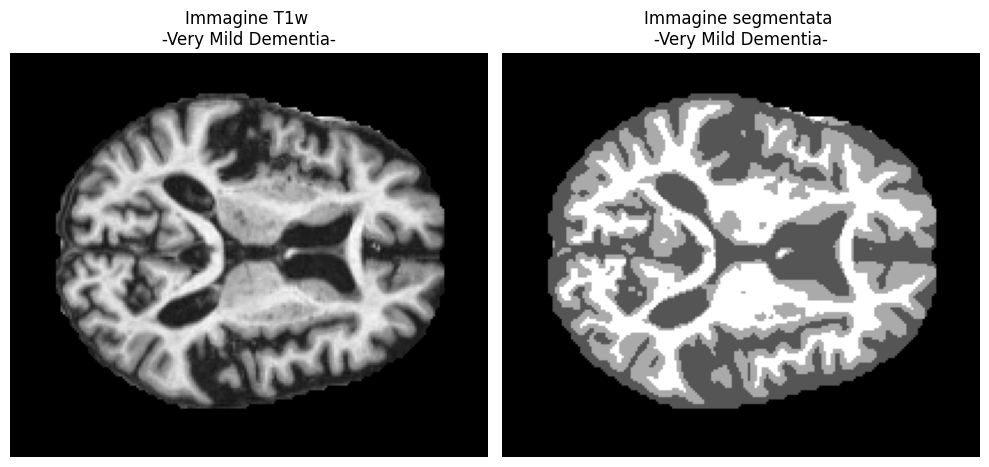

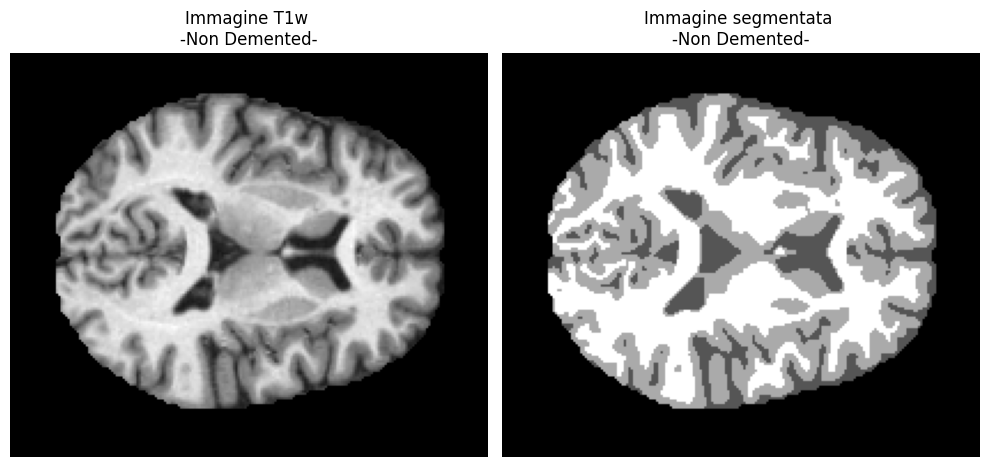

In [13]:
#VISUALIZZAZIONE DI IMMAGINI A CAMPIONE

# Scelta randomica della slice
#folders=os.listdir(mri_path)
#random_folder = random.choice(folders)
#patient_path= os.path.join(mri_path, random_folder)
#random_slice = random.choice(os.listdir(patient_path))

# Stampa di un immagine segmentata e un immagine T1w per categoria
for category in categories:
  category_path = os.path.join(oasis1_path, category)
  mri_segmented_path=os.path.join(category_path, 'mri segmented')
  mri_path= os.path.join(category_path, 'mri scan')
  folders=os.listdir(mri_path)
  random_folder = random.choice(folders)
  random_folder_seg= f"{random_folder.strip()} seg"

  patient_path= os.path.join(mri_path, random_folder)
  patient_path_seg= os.path.join(mri_segmented_path, random_folder_seg)

  img_path = os.path.join(patient_path, 'slice_85.png')
  img = mpimg.imread(img_path)
  img_seg_path = os.path.join(patient_path_seg, 'slice_85.png')
  img_seg = mpimg.imread(img_seg_path)

  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  axes[0].imshow(img)
  axes[0].set_title(f"Immagine T1w \n-{category}-")
  axes[0].axis('off')

  axes[1].imshow(img_seg)
  axes[1].set_title(f"Immagine segmentata \n-{category}-")
  axes[1].axis('off')

  plt.tight_layout()
  plt.show()

4 valori differenti: [0.         0.33333334 0.6666667  1.        ]




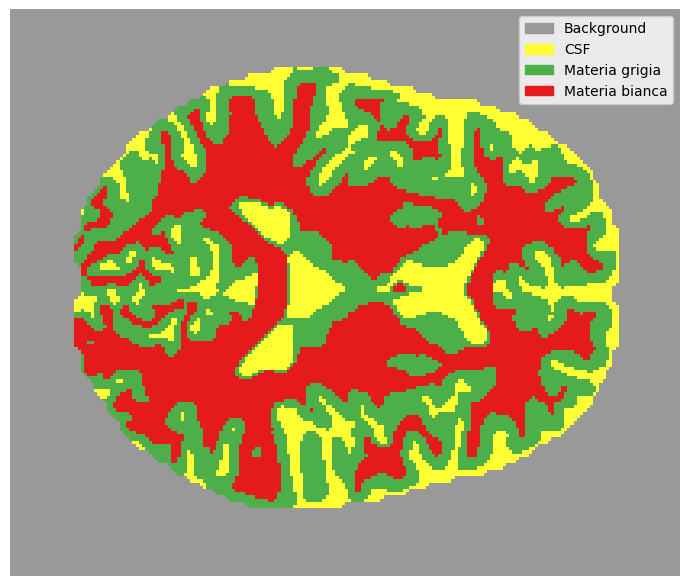

In [14]:
# Visualizzazione con etichette delle immagini segmentate

# Scelta di un immagine segmentata (parte commentata per randomizzazione)

#category='Very Mild Dementia'
#category_path = os.path.join(oasis1_path, category)
#mri_segmented_path = os.path.join(category_path, 'mri segmented')
#folders = os.listdir(mri_segmented_path)
#random_folder = random.choice(folders)
#patient_path = os.path.join(mri_segmented_path, random_folder)
#random_slice = random.choice(os.listdir(patient_path))
#img_seg_path = os.path.join(patient_path, random_slice)

img_seg = mpimg.imread(img_seg_path)
img_seg = img_seg[:, :, 0]

labels=['Background', 'CSF', 'Materia grigia', 'Materia bianca']
valori_unici = np.unique(img_seg)
print(f"{len(valori_unici)} valori differenti: {valori_unici}\n\n")

# creazione della leggenda e visualizzazione
cmap = plt.cm.Set1_r
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img_seg, cmap=cmap)

patches = []
for i, val in enumerate(valori_unici):
  patch = mpatches.Patch(color=cmap(val), label=labels[i])
  patches.append(patch)
ax.legend(handles=patches, loc='upper right')

ax.axis('off')
plt.tight_layout()
plt.show()

I valori dell'output segmentato sono normalizzati e lo standard è:

| Valore         | Etichetta         |  
|----------------|-------------------|
| `0.0`          | **Background**     |
| `0.33333334`   | **CSF**            |
| `0.6666667`    | **Materia Grigia** |
| `1.0`          | **Materia Bianca** |

### **OPERAZIONI SU DIMENSIONI E CANALI** delle immagini

In [15]:
# Check dimensioni e canali

images_dimentions=set()
images_channels=set()

# Per ognni immagine in ogni categoria salva dimensioni e numero di canale negli insiemi
for category in categories:
    category_path = os.path.join(oasis1_path, category)
    mri_path= os.path.join(category_path, 'mri scan')
    for patient in os.listdir(mri_path):
      patient_path=os.path.join(mri_path, patient)
      file_path=os.path.join(patient_path, '.DS_Store')
      if os.path.isfile(file_path):
        os.remove(file_path)
      images= os.listdir(os.path.join(mri_path, patient))

      for image in images:
        image_path=os.path.join(patient_path, image)
        i = mpimg.imread(image_path)
        w, h = i.shape[:2]
        images_dimentions.add((w, h))

        if len(i.shape) == 3:
          channels = i.shape[2]
        else:
          channels = 1
        images_channels.add(channels)

# Controllo del numero di elementi negli insiemi
if len(images_dimentions) == 1:
  print("tutte le immagini hanno le stesse dimensioni", images_dimentions.pop())
else:
  print("NON tutte le immagini hanno le stesse dimensioni:")
  for dim in images_dimentions:
        print(" ", dim)

if len(images_channels) == 1:
    print("tutte le immagini hanno lo stesso numero di canali:", images_channels.pop())
else:
    print("NON tutte le immagini hanno lo stesso numero di canali:")
    for ch in images_channels:
        print(" ", ch)

tutte le immagini hanno le stesse dimensioni (176, 208)
tutte le immagini hanno lo stesso numero di canali: 4


In [16]:
# Conversione delle immagini MRI in scale di grigi
# Utilizzo Grayscale = 0.299 * R + 0.587 * G + 0.114 * B

for category in categories:
    category_path = os.path.join(oasis1_path, category)
    mri_path= os.path.join(category_path, 'mri scan')
    for patient in os.listdir(mri_path):
        patient_path = os.path.join(mri_path, patient)
        file_path = os.path.join(patient_path, '.DS_Store')
        if os.path.isfile(file_path):
            os.remove(file_path)
        images = os.listdir(os.path.join(mri_path, patient))

        for image in images:
            image_path = os.path.join(patient_path, image)
            i = mpimg.imread(image_path)

            if len(i.shape) == 3 and i.shape[2] >= 3:
                i_rgb = i[..., :3]

                i_gray = 0.299 * i_rgb[..., 0] + 0.587 * i_rgb[..., 1] + 0.114 * i_rgb[..., 2]
                i_gray = (i_gray * 255).astype(np.uint8)
                gray_img = Image.fromarray(i_gray)
                gray_img.save(image_path)

# Check del nuovo numero di canali
images_channels=set()
for category in categories:
    category_path = os.path.join(oasis1_path, category)
    mri_path= os.path.join(category_path, 'mri scan')
    for patient in os.listdir(mri_path):
      patient_path=os.path.join(mri_path, patient)
      images= os.listdir(os.path.join(mri_path, patient))

      for image in images:
        image_path=os.path.join(patient_path, image)
        i = mpimg.imread(image_path)

        if len(i.shape) == 3:
          channels = i.shape[2]
        else:
          channels = 1
        images_channels.add(channels)

if len(images_channels) == 1:
    print("tutte le immagini hanno lo stesso numero di canali:", images_channels.pop())
else:
    print("NON tutte le immagini hanno lo stesso numero di canali:")
    for ch in images_channels:
        print(" ", ch)

tutte le immagini hanno lo stesso numero di canali: 1


### **DEVIAZIONE STANDARD E MSE**

 **DEVIAZIONE STANDARD --> misura dove variano di più i pixel**

- STD ALTA: molta variabilità nei valori dei pixel

- STD BASSA: poca variabilità nei valori dei pixel

**MEAN SQUARE ERROR --> misura quanto ogni pixel si allontana dalla media**

- MSE ALTO: alta variabilità intra-classe

- MSE BASSO: bassa variabilità intra-classe

In [17]:
# Calcolo della deviazione standard e mse

std_interclasse= {}
mse_interclasse={}
std_intraclasse={}
mse_intraclasse={}


selected_slices = ['slice_60.png', 'slice_85.png', 'slice_103.png', 'slice_120.png']  # Esempio: nomi delle slice

for name in selected_slices:  #for name in images per prendere tutte le immagini
  slices_all_categories = []
  for category in categories:
    slices = []
    category_path = os.path.join(oasis1_path, category)
    mri_path= os.path.join(category_path, 'mri scan')
    for patient in os.listdir(mri_path):
      patient_path=os.path.join(mri_path, patient)
      slice_of_interest= os.path.join(patient_path, name)
      i = Image.open(slice_of_interest)
      i_array = np.array(i)
      slices.append(i_array)

    if slices:
        slices_stack_interclasse = np.stack(slices)
        std_map_interclasse = np.std(slices_stack_interclasse, axis=0)
        mean_slice_interclasse = np.mean(slices_stack_interclasse, axis=0)
        mse_map_interclasse = np.mean((slices_stack_interclasse - mean_slice_interclasse) ** 2, axis=0)
        mse_interclasse[(name,category)] = mse_map_interclasse
        std_interclasse[(name, category)] = std_map_interclasse

        slices_all_categories.extend(slices)

  if slices_all_categories:
        slices_stack_intraclasse = np.stack(slices_all_categories)
        std_map_intraclasse = np.std(slices_stack_intraclasse, axis=0)
        mean_slice_intraclasse = np.mean(slices_stack_intraclasse, axis=0)
        mse_map_intraclasse = np.mean((slices_stack_intraclasse - mean_slice_intraclasse) ** 2, axis=0)
        std_intraclasse[name] = std_map_intraclasse
        mse_intraclasse[name] = mse_map_intraclasse

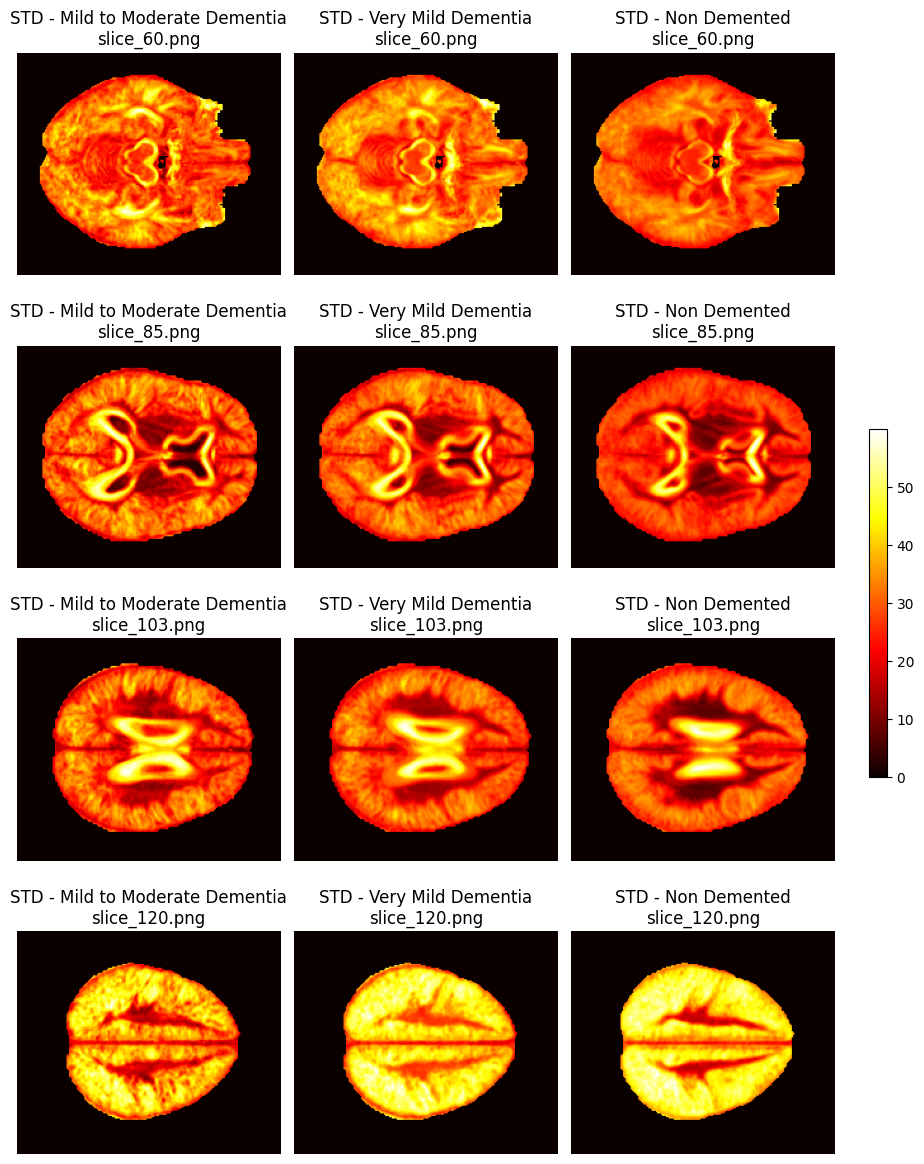

In [18]:
#  Visualizzazione della deviazione standard (sulla stessa slice) intra classe

columns = 3
imgs = len(std_interclasse)
rows = math.ceil(imgs / columns)
plt.figure(figsize=(columns * 3, rows * 3))

for idx, ((name, category), std_map_interclasse) in enumerate((std_interclasse.items())):
    plt.subplot(rows, columns, idx + 1)
    im = plt.imshow(std_map_interclasse, cmap='hot')
    plt.title(f"STD - {category}\n{name}")
    plt.axis('off')

plt.tight_layout()
plt.colorbar(im, ax=plt.gcf().get_axes(), fraction=0.02, pad=0.04)
plt.show()

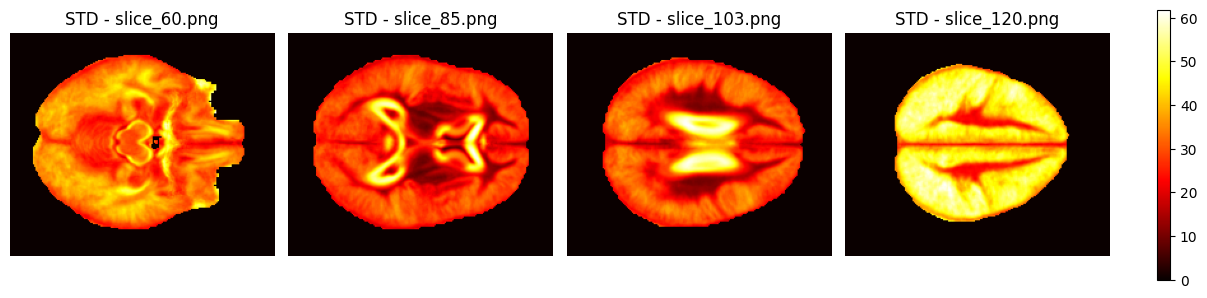

In [19]:
# Visualizzazione della deviazione standard (sulla stessa slice) inter classe

columns = 4
imgs = len(std_intraclasse)
rows = math.ceil(imgs / columns)
plt.figure(figsize=(columns * 3, rows * 3))

for idx, (name, std_map_intraclasse) in enumerate(std_intraclasse.items()):
    plt.subplot(rows, columns, idx + 1)
    im = plt.imshow(std_map_intraclasse, cmap='hot')
    plt.title(f"STD - {name}")
    plt.axis('off')

plt.tight_layout()
plt.colorbar(im, ax=plt.gcf().get_axes(), fraction=0.02, pad=0.04)
plt.show()

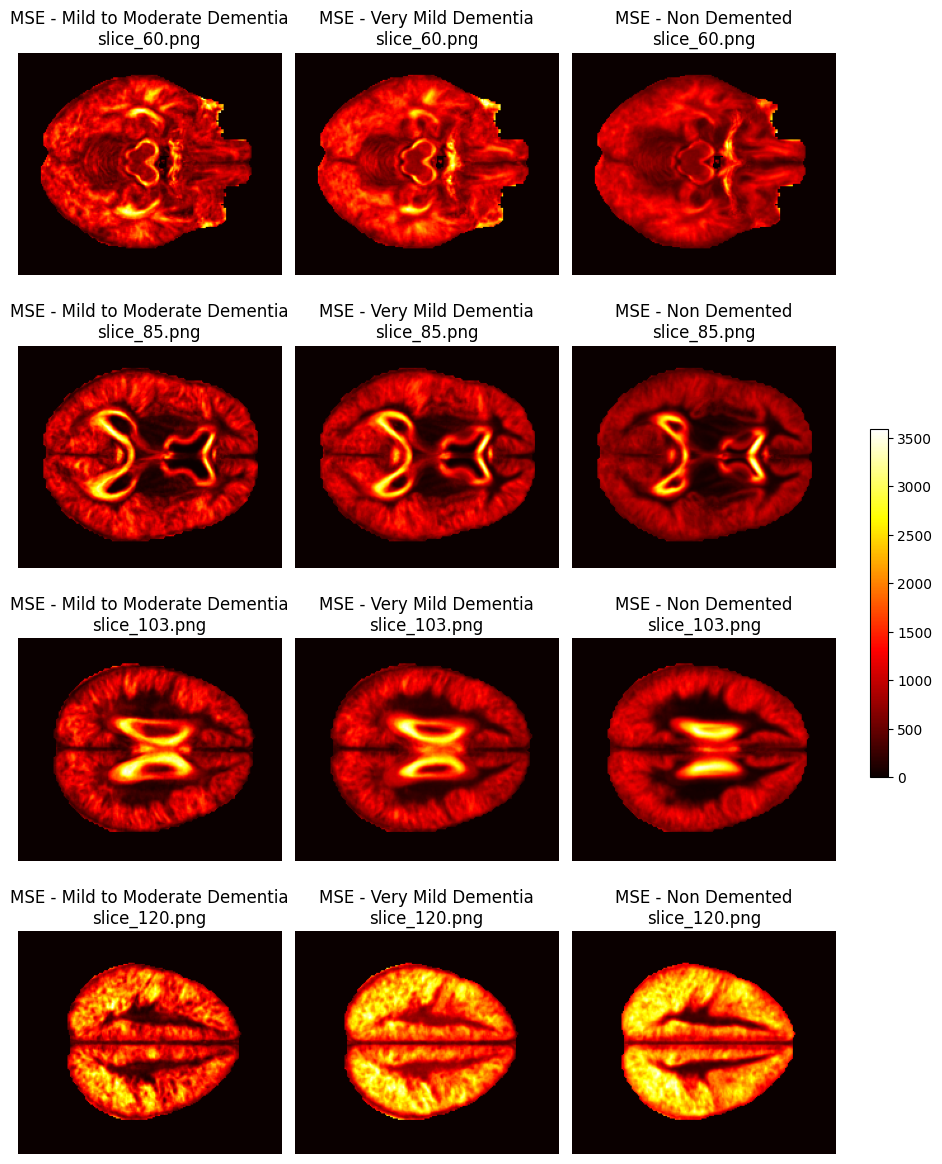

In [20]:
# Visualizzazione dell'MSE (sulla stessa slice) intra classe

columns = 3
imgs = len(mse_interclasse)
rows = math.ceil(imgs / columns)
plt.figure(figsize=(columns * 3, rows * 3))

for idx, ((name, category), mse_map_interclasse) in enumerate(mse_interclasse.items()):
    plt.subplot(rows, columns, idx + 1)
    im = plt.imshow(mse_map_interclasse, cmap='hot')
    plt.title(f"MSE - {category}\n{name}")
    plt.axis('off')

plt.tight_layout()
plt.colorbar(im, ax=plt.gcf().get_axes(), fraction=0.02, pad=0.04)
plt.show()

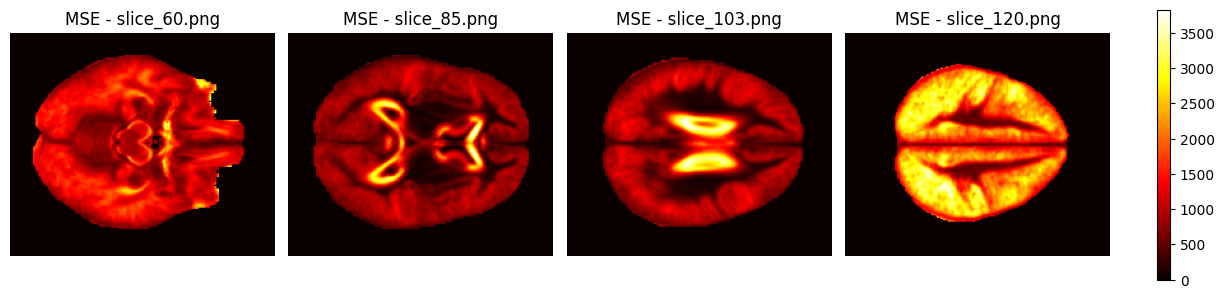

In [21]:
# Visualizzazione dell'MSE (sulla stessa slice) inter classe

columns = 4
imgs = len(mse_intraclasse)
rows = math.ceil(imgs / columns)
plt.figure(figsize=(columns * 3, rows * 3))

for idx, (name, mse_map_intraclasse) in enumerate(mse_intraclasse.items()):
    plt.subplot(rows, columns, idx + 1)
    im = plt.imshow(mse_map_intraclasse, cmap='hot')
    plt.title(f"MSE - {name}")
    plt.axis('off')

plt.tight_layout()
plt.colorbar(im, ax=plt.gcf().get_axes(), fraction=0.02, pad=0.04)
plt.show()

### **DIVISIONE IN TRAINING SET E TEST SET**

In [22]:
# Divisione in training e test set

labeled_patients=[]
segmented_patients=[]

for cat in categories:
  category_path = os.path.join(oasis1_path, cat)
  mri_path= os.path.join(category_path, 'mri scan')
  mri_segmented_path=os.path.join(category_path, 'mri segmented')
  for patient in os.listdir(mri_path):
    patient_seg= f"{patient.strip()} seg"
    patient_path=os.path.join(mri_path, patient)
    patient_seg_path=os.path.join(mri_segmented_path, patient_seg)
    labeled_patients.append((cat, patient))
    segmented_patients.append((cat, patient_seg))

df=pd.DataFrame(labeled_patients, columns=["label", "patient_id"])
df_seg=pd.DataFrame(segmented_patients, columns=["label", "patient_id"])

In [23]:
from sklearn.model_selection import train_test_split

train_x, test_x = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

train_ids = train_x['patient_id'].tolist()
test_ids = test_x['patient_id'].tolist()

train_y = df_seg[df_seg['patient_id'].isin([f"{pid} seg" for pid in train_ids])]
test_y = df_seg[df_seg['patient_id'].isin([f"{pid} seg" for pid in test_ids])]

print("Numero di pazienti segmentati in train_y:", len(train_y))
print("Numero di pazienti in train_x:", len(train_x))
print("Numero di pazienti segmentati in test_y:", len(test_y))
print("Numero di pazienti in test_x:", len(test_x))

Numero di pazienti segmentati in train_y: 204
Numero di pazienti in train_x: 204
Numero di pazienti segmentati in test_y: 52
Numero di pazienti in test_x: 52


### **CONVERSIONE IMMAGINI SEGMENTATE IN MAPPE DI CLASSI**

In [24]:
# Funzione per la conversione di immagine segmentata in una mappa di classi intere
value_to_class = {
    0.0: 0,
    1/3: 1,
    2/3: 2,
    1.0: 3
}

def class_map(img, d):
  class_map = np.zeros_like(img, dtype=np.uint8)
  for val, class_id in d.items():
    mask = np.isclose(img, val)
    class_map[mask] = class_id
  return class_map

In [25]:
# Conversione delle immagini segmentate in mappe

for category in categories:
    category_path = os.path.join(oasis1_path, category)
    mri_segmented_path=os.path.join(category_path, 'mri segmented')
    for patient in os.listdir(mri_segmented_path):
      patient_path= os.path.join(mri_segmented_path, patient)
      for filename in os.listdir(patient_path):
        img_path = os.path.join(patient_path, filename)
        img_seg = mpimg.imread(img_path)
        img_seg = img_seg[:, :, 0]
        classmap = class_map(img_seg, value_to_class)
        save_path = os.path.join(patient_path, filename.replace(".png", ".npy"))
        np.save(save_path, classmap)

### **SBILANCIAMENTO TRA CLASSI DELLA SEGMENTAZIONE**

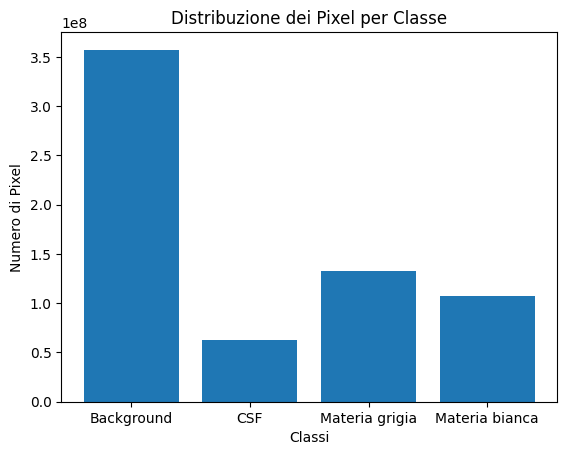

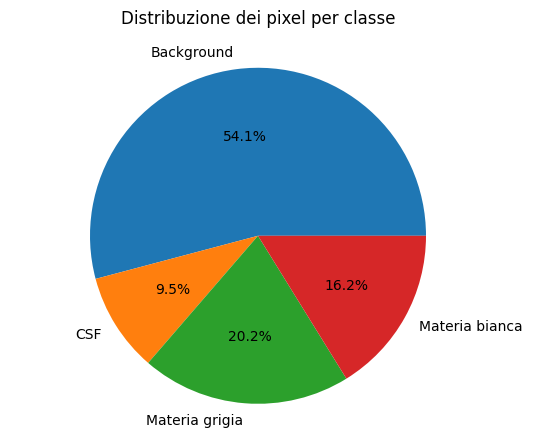

In [26]:
# Calcolo del numero di pixel per ogni classe per vedere se sono presenti sbilanciamenti

labels = ['Background', 'CSF', 'Materia grigia', 'Materia bianca']
total_counts = np.zeros(4, dtype=np.int64)
image_count = 0

for category in categories:
    category_path = os.path.join(oasis1_path, category)
    mri_segmented_path=os.path.join(category_path, 'mri segmented')
    for patient in os.listdir(mri_segmented_path):
      patient_path= os.path.join(mri_segmented_path, patient)
      for filename in os.listdir(patient_path):
        if not filename.endswith('.npy'):
          continue
        file_path = os.path.join(patient_path, filename)
        class_map = np.load(file_path)
        pixel_counts = np.bincount(class_map.flatten(), minlength=4)
        total_counts += pixel_counts
        image_count += 1
avg_counts = total_counts / image_count


# Visualizzazione tramite istogramma
plt.bar(labels, total_counts)
plt.xlabel('Classi')
plt.ylabel('Numero di Pixel')
plt.title('Distribuzione dei Pixel per Classe')
plt.show()

# Visualizzazione tramite grafico a torta
plt.pie(total_counts, labels=labels, autopct='%1.1f%%', startangle=0)
plt.title('Distribuzione dei pixel per classe',pad=20)
plt.axis('equal')
plt.show()

In [252]:
# Calcolo dei pesi per la loss function

pixels = avg_counts.sum()
class_weights = pixels /(4* avg_counts )

for class_id, weight in enumerate(class_weights):
  print(f"Classe {labels[class_id]}: Peso = {weight:.4f}")
class_weights = np.array(class_weights, dtype=np.float32)


Classe Background: Peso = 0.4618
Classe CSF: Peso = 2.6230
Classe Materia grigia: Peso = 1.2402
Classe Materia bianca: Peso = 1.5450


# **DEFINIZIONE DELLA U NET** per la segmentazione

## *Funzioni ausiliarie al forward pass*

### **Funzioni di pooling e upsampling**

In [335]:
# Max pooling

def max_pooling(img, pool_size=2, stride=2):
  if img.ndim == 3:
    img = img[:, :, :, np.newaxis]
  batch_size, img_height, img_width, img_channels = img.shape
  pool_height, pool_width = (pool_size, pool_size)
  output_height = (img_height - pool_height) // stride + 1
  output_width = (img_width - pool_width) // stride + 1
  output = np.zeros((batch_size, output_height, output_width, img_channels))
  for b in range(batch_size):
    for i in range(output_height):
      for j in range(output_width):
        row=i*stride
        column=j*stride
        for c in range(img_channels):
          window = img[b, row:row + pool_height, column:column + pool_width, c]
          output[b,i, j, c] = np.max(window)
  return output

In [336]:
# Upsampling

def upsample(img, scale=2):
  if img.ndim == 3:
    img = img[:, :, :, np.newaxis]

  batch_size, img_height, img_width, img_channels = img.shape
  output_height=img_height*scale
  output_width=img_width*scale
  output = np.zeros((batch_size, output_height, output_width, img_channels))
  for b in range(batch_size):
    for row in range(img_height):
      for column in range(img_width):
        for i in range(scale):
          for j in range(scale):
            for c in range(img_channels):
              output[b, row * scale + i, column * scale + j, c] = img[b,row, column,c]
  return output

### **Funzione di perdita** (loss function)

In [337]:
# Loss function e funzioni ausiliarie

def onehot_encoding(targets, n_classes):
  one_hot = np.zeros((*targets.shape, n_classes), dtype=np.uint8)
  for i in range(n_classes):
    one_hot[..., i] = (targets == i).astype(np.uint8)
  return one_hot



def weighted_cross_entropy_loss(targets, predictions, class_weights):
  epsilon = 1e-7
  log_predictions = np.log(predictions + epsilon)
  cross_entropy = -np.sum(targets * log_predictions, axis=-1)
  weights = np.sum(targets * class_weights, axis=-1)
  weighted_cross_entropy = cross_entropy * weights
  loss_per_batch = np.sum(weighted_cross_entropy, axis=(1, 2))
  loss = np.mean(loss_per_batch)

  return loss


### **Funzioni di attivazione**

In [338]:
# ReLU

def ReLU(img):
  return np.maximum(0, img)

In [339]:
# Softmax - per rendere l'output in probabilità per classe

def softmax(predictions, temperature=0.5):
    if predictions.ndim != 4:
        raise ValueError(f"Expected predictions of shape (B, H, W, C), got {predictions.shape}")

    scaled_preds = predictions / temperature
    exp_preds = np.exp(scaled_preds - np.max(scaled_preds, axis=-1, keepdims=True))
    sum_exp_preds = np.sum(exp_preds, axis=-1, keepdims=True)
    softmax_output = exp_preds / sum_exp_preds
    return softmax_output


### **Funzioni di ottimizzazione**

In [368]:
def apply_gradients(filters, final_filters, grads, learning_rate):

  filters["encoder1"] -= learning_rate * grads["encoder"][0]
  filters["encoder2"] -= learning_rate * grads["encoder"][1]

  filters["decoder1"] -= learning_rate * grads["decoder"][0]
  filters["decoder2"] -= learning_rate * grads["decoder"][1]

  filters["bottleneck1"] -= learning_rate * grads["bottleneck"][0]
  filters["bottleneck2"] -= learning_rate * grads["bottleneck"][1]

  final_filters -= learning_rate * grads["final"]

  return filters, final_filters


## *Funzioni per il forward pass*

In [341]:
# Funzione di convoluzione con più filtri
def convolve(imgs, kernels):
  if imgs.ndim == 3:
    imgs = imgs[:, :, :, np.newaxis]

  batch_size, img_height, img_width, imgs_channels = imgs.shape
  n_kernels, ker_height, ker_width, _ = kernels.shape
  pad_h = ker_height // 2
  pad_w = ker_width // 2
  padded_imgs = np.pad(imgs, pad_width=((0, 0), (pad_h, pad_h), (pad_w, pad_w), (0, 0)),
                         mode='constant', constant_values=0)

  output = np.zeros((batch_size, img_height, img_width, n_kernels))
  for i in range(batch_size):
    img = padded_imgs[i]
    for row in range(img_height):
      for column in range(img_width):
        for k in range(n_kernels):
          kernel = kernels[k]
          window = img[row:row + ker_height, column:column + ker_width, :]
          output[i, row, column, k] = np.sum(window * kernel)
  return output


In [342]:
# Convoluzione finale

def final_convolve_1x1(imgs, filters):
  img_batch, img_height, img_width, img_channels = imgs.shape
  _, _, _, filters_channels = filters.shape

  output = np.zeros((img_batch, img_height, img_width, filters_channels))
  for b in range(img_batch):
    for h in range(img_height):
      for w in range(img_width):
        for oc in range(filters_channels):
          for ic in range(img_channels):
            output[b, h, w, oc] += imgs[b, h, w, ic] * filters[0, 0, ic, oc]
  return output

In [343]:
# Funzione per la concatenazione

def concatenate(img_contr, img_exp):
  if img_contr.ndim == 3:
    img_contr = img_contr[:, :, :, np.newaxis]
  if img_exp.ndim == 3:
        img_exp = img_exp[:, :, :, np.newaxis]
  batch_size, contr_height, contr_width , _= img_contr.shape
  _, exp_height, exp_width, _ = img_exp.shape
  if contr_height == exp_height and contr_width == exp_width:
    concatenated = np.concatenate((img_contr, img_exp), axis=3)
    return concatenated

In [344]:
# Encoder

def encoder(imgs, filters):
  blocks=[]
  saved_enc = {}
  saved_enc["input_convolve"] = imgs

  c=convolve(imgs, filters["encoder1"])
  saved_enc["conv0"] = c
  c=ReLU(c)
  blocks.append(c)

  c=convolve(c, filters["encoder2"])
  saved_enc["conv1"] = c
  c=ReLU(c)
  blocks.append(c)

  c=max_pooling(c)

  return c, blocks, saved_enc

In [345]:
# Decoder

def decoder(imgs, blocks, filters):
  saved = {}

  saved["input_upsample"] = imgs
  c = upsample(imgs)
  saved["upsampled"] = c

  skip = blocks[1]
  saved["skip"] = skip

  c = concatenate(c, skip)
  saved["concatenated"] = c

  c = convolve(c, filters["decoder1"])
  saved["conv0"] = c
  c = ReLU(c)

  saved["input_conv1"] = c
  c = convolve(c, filters["decoder2"])
  saved["conv1"] = c
  c = ReLU(c)

  return c, saved


In [346]:
# Bottleneck

def bottleneck(imgs, filters):
  saved_b = {}

  saved_b["input_convolve0"] = imgs
  c=convolve(imgs, filters["bottleneck1"])
  saved_b["convolved0"] = c
  c=ReLU(c)

  saved_b["input_convolve1"] = c
  c=convolve(c, filters["bottleneck2"])
  saved_b["convolved1"] = c
  c=ReLU(c)

  return c , saved_b

## *Funzioni ausiliarie al backward pass*

### **Funzioni di pooling e upsampling**

In [347]:
# Derivata del max pooling

def max_pooling_backward(dout, input, pool_size, stride):

  batch_size, height, width, channels = input.shape
  out_height, out_width = dout.shape[1], dout.shape[2]

  output = np.zeros_like(input)

  for i in range(batch_size):
    for h in range(out_height):
      for w in range(out_width):
        for c in range(channels):
          h_start = h * stride
          h_end = h_start + pool_size
          w_start = w * stride
          w_end = w_start + pool_size

          window = input[i, h_start:h_end, w_start:w_end, c]
          max_pos = np.unravel_index(np.argmax(window), window.shape)

          output[i, h_start + max_pos[0], w_start + max_pos[1], c] += dout[i, h, w, c]

  return output


In [348]:
# Derivata dell'upsampling

def upsample_backward(dout, img, scale=2):
  if img.ndim == 3:
      img = img[:, :, :, np.newaxis]
  batch_size, output_height, output_width, img_channels = dout.shape

  img_height = output_height // scale
  img_width = output_width // scale

  # Creiamo una variabile di output per accumulare i gradienti
  dinput = np.zeros_like(img)

  for b in range(batch_size):
    for row in range(img_height):
      for column in range(img_width):
        for i in range(scale):
          for j in range(scale):
            for c in range(img_channels):
              dinput[b, row, column, c] += dout[b, row * scale + i, column * scale + j, c]

  return dinput


### **Funzioni di attivazione**

In [349]:
# Derivata della ReLU

def ReLU_backward(grad, input):
  return grad * (input > 0)

### **Funzioni di perdita** (loss function)

In [350]:
# Gradiente della funzione di loss
def grad(targets, predictions, class_weights):
  weights = np.sum(targets * class_weights, axis=-1)
  weights = weights[..., np.newaxis]
  grad = (predictions - targets) * weights
  grad /= np.prod(targets.shape)

  return grad

## *Funzioni per il backward pass*

In [351]:
# Derivata della convoluzione con più filtri

def convolve_backward(dout, input, kernels):
  if input.ndim == 3:
    input = input[:, :, :, np.newaxis]
  if dout.ndim == 3:
    dout = dout[:, :, :, np.newaxis]

  batch_size, img_height, img_width, input_channels = input.shape
  n_kernels, ker_height, ker_width, _ = kernels.shape
  pad_h = ker_height // 2
  pad_w = ker_width // 2

  padded_input = np.pad(input, ((0, 0), (pad_h, pad_h), (pad_w, pad_w), (0, 0)), mode='constant')

  dinput = np.zeros_like(padded_input, dtype=np.float64)
  dkernel = np.zeros_like(kernels, dtype=np.float64)


  for b in range(batch_size):
    for h in range(img_height):
      for w in range(img_width):
        for k in range(n_kernels):
          kernel = kernels[k]
          window = padded_input[b, h:h + ker_height, w:w + ker_width, : 1]

          dkernel[k] += window * dout[b, h, w, k]
          dinput[b, h:h + ker_height, w:w + ker_width, :] += kernel * dout[b, h, w, k]

  dinput = dinput[:, pad_h:pad_h + img_height, pad_w:pad_w + img_width, :]

  return dinput, dkernel


In [352]:
# Derivata della convoluzione finale

def final_convolve_1x1_backward(dout, imgs, filters):
  img_batch, img_height, img_width, img_channels = imgs.shape
  _, _, _, filters_channels = filters.shape

  dimgs = np.zeros_like(imgs)
  dfilters = np.zeros_like(filters)

  for b in range(img_batch):
    for h in range(img_height):
      for w in range(img_width):
        for oc in range(filters_channels):
          for ic in range(img_channels):
            dimgs[b, h, w, ic] += dout[b, h, w, oc] * filters[0, 0, ic, oc]
            dfilters[0, 0, ic, oc] += imgs[b, h, w, ic] * dout[b, h, w, oc]

  return dimgs, dfilters

In [353]:
# Derivata della concatenazione

def concatenate_backward(dout, img_contr, img_exp):
  c1 = img_contr.shape[-1]
  c2 = img_exp.shape[-1]
  dimg_contr = dout[..., :c1]
  dimg_exp = dout[..., c1:c1 + c2]
  return dimg_contr, dimg_exp

In [354]:
# Encoder backward

def encoder_backward(dout, blocks, filters, saved_enc):
  grads = [None, None]

  dmaxpool = max_pooling_backward(dout, blocks[1], pool_size=2, stride=2)

  dout = ReLU_backward(dmaxpool, saved_enc["conv1"])
  dconv1, grads[1] = convolve_backward(dout, blocks[0], filters["encoder1"])

  dout = ReLU_backward(dconv1, saved_enc["conv0"])
  dconv2, grads[0] = convolve_backward(dout, saved_enc["input_convolve"], filters["encoder2"])

  return dconv2, grads

In [355]:
# Decoder backwards

def decoder_backward(dout, saved, filters):
  grads = [None, None]

  drelu2 = ReLU_backward(dout, saved["conv1"])

  dconv2, grads[1] = convolve_backward(drelu2, saved["input_conv1"], filters["decoder1"])

  drelu1 = ReLU_backward(dconv2, saved["conv0"])

  dconv1, grads[0] = convolve_backward(drelu1, saved["concatenated"], filters["decoder2"])

  dupsampled, dskip = concatenate_backward(dconv1, saved["upsampled"], saved["skip"])

  dinput = upsample_backward(dupsampled, saved["input_upsample"])

  return dinput, dskip, grads


In [356]:
# Bottleneck backwards

def bottleneck_backward(dout, saved, filters):
  grads = [None, None]

  drelu2 = ReLU_backward(dout, saved["convolved1"])
  dconv2, grads[1] = convolve_backward(drelu2, saved["input_convolve1"], filters["bottleneck1"])

  drelu1 = ReLU_backward(dout, saved["convolved0"])
  dconv1, grads[0] = convolve_backward(drelu1, saved["input_convolve0"], filters["bottleneck2"])

  return dconv1, grads

## FUNZIONI DI TRAINING

In [357]:
# FORWARD
def forward_pass(input_img, target_img, filters, final_filters, class_weights, n_classes):
  saved_fwd = {}

  encoded_img, skip_connections, saved_encoder = encoder(input_img, filters)
  saved_fwd["saved_encoder"] = saved_encoder

  bottleneck_img, saved_bot= bottleneck(encoded_img, filters)
  saved_fwd["saved_bot"] = saved_bot

  decoded_img, saved_decoder = decoder(bottleneck_img, skip_connections, filters)
  saved_fwd["saved_decoder"] = saved_decoder

  saved_fwd["input_fc"] = decoded_img
  final_output = final_convolve_1x1(decoded_img, final_filters)

  saved_fwd["input_loss"] = final_output
  final_output=softmax(final_output)
  loss = weighted_cross_entropy_loss(target_img, final_output, class_weights)

  return final_output, loss, saved_fwd, skip_connections

In [358]:
# BACKWARD
def backward_pass( target_img, saved_fwd ,final_filters, filters, class_weights, skip_connections):

  grad_loss = grad(target_img, saved_fwd["input_loss"], class_weights)

  d_convolve, final_filters_grads= final_convolve_1x1_backward(grad_loss, saved_fwd["input_fc"], final_filters)

  d_decoder, d_skip, decoder_grads = decoder_backward(d_convolve, saved_fwd["saved_decoder"], filters)

  d_bot, bot_grads = bottleneck_backward(d_decoder, saved_fwd["saved_bot"], filters)

  d_encoder, encoder_grads = encoder_backward(d_bot, skip_connections, filters, saved_fwd["saved_encoder"])

  grads = {
        "encoder": encoder_grads,
        "bottleneck": bot_grads,
        "decoder": decoder_grads,
        "final": final_filters_grads
    }

  return d_encoder, grads


In [359]:
# Train step

def train_step(imgs, targets, filters, final_filters, class_weights, learning_rate, n_classes):

  output, loss, saved_fwd, skip_connections = forward_pass(imgs, targets, filters, final_filters,
                                                             class_weights, n_classes)

  final_loss, grads = backward_pass (targets, saved_fwd, final_filters, filters,
                                    class_weights, skip_connections)

  filters, final_filters = apply_gradients(filters, final_filters, grads, learning_rate)

  return loss, filters, final_filters, output


In [360]:
# Validation step

def validation_step(X_batch, y_batch, filters, final_filters, class_weights, num_classes):
  predictions, loss, _, _ = forward_pass(X_batch, y_batch, filters, final_filters, class_weights, num_classes)
  return loss


#PREPARAZIONE DATI DA PASSARE ALLA RETE

In [361]:
image_paths = []
mask_paths = []

for cat in categories:
  category_path = os.path.join(oasis1_path, cat)
  mri_path= os.path.join(category_path, 'mri scan')
  mri_segmented_path=os.path.join(category_path, 'mri segmented')
  for patient in train_ids:
    patient_img_dir = os.path.join(mri_path, patient)
    patient_mask_dir = os.path.join(mri_segmented_path, f"{patient} seg")
    if not os.path.exists(patient_img_dir) or not os.path.exists(patient_mask_dir):
      continue
    for image in os.listdir(patient_img_dir):
      img_path = os.path.join(patient_img_dir, image)
      mask_name = image.replace(".png", ".npy")
      mask_path = os.path.join(patient_mask_dir, mask_name)
      image_paths.append(img_path)
      mask_paths.append(mask_path)


# MOMENTANEO PER DIMINUIRE IL TEMPO DI TRAINING
combined = list(zip(image_paths, mask_paths))
random.shuffle(combined)
image_paths, mask_paths = zip(*combined)
image_paths = list(image_paths[:60])
mask_paths = list(mask_paths[:60])


In [362]:
# Funzione per creare i batch

def batch_generator(image_paths, mask_paths, batch_size, num_classes=4):
  num_samples = len(image_paths)
  indices = np.arange(num_samples)
  np.random.shuffle(indices)

  for start in range(0, num_samples, batch_size):
    end = min(start + batch_size, num_samples)
    batch_idx = indices[start:end]

    X = []
    y = []
    for i in batch_idx:
      img = Image.open(image_paths[i])
      img = np.array(img, dtype=np.float32) / 255.0
      mask = np.load(mask_paths[i])
      X.append(img[..., np.newaxis])

      one_hot = onehot_encoding(mask, num_classes)
      y.append(one_hot)

    X = np.stack(X)
    y = np.stack(y)
    yield X, y

In [363]:
# Divisione in fold

k = 5
total = len(image_paths)
fold_size = total // k

folds = []
for i in range(k):
  start = i * fold_size
  end = (i + 1) * fold_size if i < k - 1 else total
  folds.append((image_paths[start:end], mask_paths[start:end]))

In [364]:
# Parametri e filtri

num_epochs = 4
n_classes = 4
batch_size = 10
learning_rate = 1e-6
n_filtri=3


filters = {
    "encoder1": np.random.rand(n_filtri, 3, 3,1) * 0.1,
    "encoder2": np.random.rand(n_filtri, 3, 3,1) * 0.1,
    "decoder1": np.random.rand(n_filtri, 3, 3,1) * 0.1,
    "decoder2": np.random.rand(n_filtri, 3, 3,1) * 0.1,
    "bottleneck1": np.random.rand(n_filtri, 3, 3,1) * 0.1,
    "bottleneck2": np.random.rand(n_filtri, 3, 3,1) * 0.1
}

final_filters = np.random.rand(1, 1, n_filtri, n_classes)

In [ ]:
# Training con k-fold

for fold in range(k):
  print(f"\n Fold {fold + 1}/{k}")
  val_image_paths, val_mask_paths = folds[fold]

  train_image_paths = []
  train_mask_paths = []
  for i in range(k):
    if i != fold:
      train_image_paths += folds[i][0]
      train_mask_paths += folds[i][1]

  for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}: Inizio addestramento...")
    gen = batch_generator(train_image_paths, train_mask_paths, batch_size=8)

    num_batches = len(train_image_paths) // batch_size
    if len(train_image_paths) % batch_size != 0:
      num_batches += 1
    for batch_idx in range(num_batches):
      X_batch, y_batch = next(gen)
      loss, filters, final_filters, predictions = train_step(X_batch, y_batch, filters, final_filters, class_weights, learning_rate, 4)
      print(f"Epoch {epoch + 1}, Batch {batch_idx + 1}/{num_batches}, Loss: {loss}")
      save_predicted_images(predictions, epoch, fold)

    val_gen = batch_generator(val_image_paths, val_mask_paths, batch_size=8)
    val_loss_total = 0
    val_batches = len(val_image_paths) // batch_size
    if len(val_image_paths) % batch_size != 0:
        val_batches += 1

    for _ in range(val_batches):
      X_val, y_val = next(val_gen)
      val_loss = validation_step(X_val, y_val, filters, final_filters, class_weights, 4)
      val_loss_total += val_loss

    avg_val_loss = val_loss_total / val_batches
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss}")



 Fold 1/5
Epoch 1/4: Inizio addestramento...
Epoch 1, Batch 1/5, Loss: 126874.4425107314
Epoch 1, Batch 2/5, Loss: 121057.50771302491
Epoch 1, Batch 3/5, Loss: 112301.97216910223
Epoch 1, Batch 4/5, Loss: 120932.79037768481
Epoch 1, Batch 5/5, Loss: 113590.90387281595
Epoch 1, Validation Loss: 115198.56244154007
Epoch 2/4: Inizio addestramento...
Epoch 2, Batch 1/5, Loss: 114283.0799312563
Epoch 2, Batch 2/5, Loss: 105951.401986193
Epoch 2, Batch 3/5, Loss: 122994.48546488861
